# Linear Regression models for Longitudinal data 

### Life expectancy vs Health expenditure

Goals: 
- analyze life expectancy in relation to health expenditure
- compare different linear regression models and python implementations

Data Sources:
- Life expectancy: OurWorldInData, https://ourworldindata.org/grapher/life-expectancy?time=..&country=~OWID_WRL
- Health expenditure: WHO's Global Health Expenditure Database (GHED), http://apps.who.int/nha/database/Home/IndicatorsDownload/en
  
Libraries
- linear regression implementations: `scikit-learn`, `statsmodel`, `linearmodels`
- visualization: `matplotlib`, `seaborn`
- other libraries: `pandas`, `numpy`, `scipy`

### Step 1: Load and prepare data
#### 1.1.- Load data from `life-expectancy.csv`

In [1]:
FILENAME="data/life-expectancy.csv"
import pandas as pd
df_y = pd.read_csv(FILENAME)
df_y

,Entity,Code,Year,Life expectancy (years)
0,Afghanistan,AFG,1950,27.638
1,Afghanistan,AFG,1951,27.878
2,Afghanistan,AFG,1952,28.361
3,Afghanistan,AFG,1953,28.852
4,Afghanistan,AFG,1954,29.350
...,...,...,...,...
19023,Zimbabwe,ZWE,2015,59.534
19024,Zimbabwe,ZWE,2016,60.294
19025,Zimbabwe,ZWE,2017,60.812
19026,Zimbabwe,ZWE,2018,61.195


#### 1.2.- Load data from `health-expenditure.csv`

In [2]:
df_x = pd.read_csv('data/health_expenditure.csv', sep='|')
df_x

,Country Name,Country Code,Indicator Code,Year,Value
0,Antigua and Barbuda,ATG,sha11.HF,2000.0,444.939432
1,Antigua and Barbuda,ATG,sha11.HF,2001.0,497.096598
2,Antigua and Barbuda,ATG,sha11.HF,2002.0,512.317693
3,Antigua and Barbuda,ATG,sha11.HF,2003.0,569.649036
4,Antigua and Barbuda,ATG,sha11.HF,2004.0,547.871067
...,...,...,...,...,...
96522,Malawi,MWI,sha11.DIS.2.1_ext,2015.0,0.165924
96523,Malawi,MWI,sha11.DIS.2.1_ext,2016.0,0.144373
96524,Cambodia,KHM,sha11.DIS.2.1_ext,2015.0,0.978661
96525,Cambodia,KHM,sha11.DIS.2.1_ext,2016.0,1.179586


#### 1.3.- Clean NaN, adapt columns and merge into a single dataframe

In [3]:
# skip rows with (how=any) null values
df_x = df_x.dropna()
df_x.columns = ['Entity', 'Code', 'Indicator Code','Year', 'Health expenditure']
df_x = df_x.astype({'Year':'int64'})
df_x = df_x[df_x["Indicator Code"] == 'sha11.HF']
df_x.columns = ['Entity', 'Code', 'Indicator Code','Year', 'Health expenditure']
df_xy = df_x.merge(df_y)
df_xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050 entries, 0 to 3049
Data columns (total 6 columns):
Entity                     3050 non-null object
Code                       3050 non-null object
Indicator Code             3050 non-null object
Year                       3050 non-null int64
Health expenditure         3050 non-null float64
Life expectancy (years)    3050 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 166.8+ KB


### Step 2: Explore the data
#### 2.1.- Visualization

Histograms in diagonal. Scatterplot off diagonal

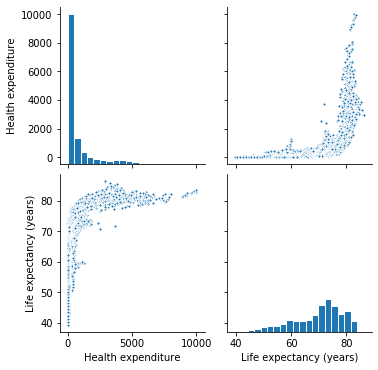

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(df_xy, vars=["Health expenditure", "Life expectancy (years)"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

According to the charts, it seems that health expenditure is associated with increase in life expectancy. Though it seems the relation is not linear. So let's assume life expectancy is associated with increase in logarithm of health expenditure. And compare correlations

#### 2.2.- Correlations. Linear vs log-transformed


In [5]:
import numpy as np
corr = np.corrcoef(df_xy['Life expectancy (years)'], df_xy['Health expenditure'])
print(corr)

[[1.         0.57565989]
 [0.57565989 1.        ]]


In [6]:
corr = np.corrcoef(df_xy['Life expectancy (years)'], np.log(df_xy['Health expenditure']))
print(corr)

[[1.         0.80981449]
 [0.80981449 1.        ]]


Our assumption make sense. Let's add to `df_xy` the new variable `health_expenditure_log` with the logarithmic transformation of Health expenditure. And visualize again histograms and relationships between variables

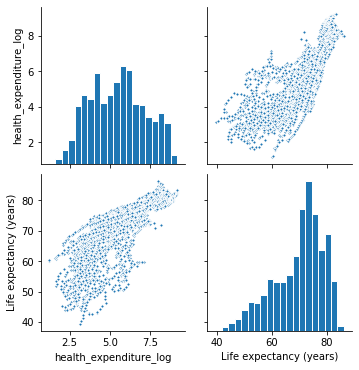

In [7]:
df_xy['health_expenditure_log'] = np.log(df_xy['Health expenditure'])
g = sns.PairGrid(df_xy, vars=["health_expenditure_log", "Life expectancy (years)"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

### Step 3: Linear Regression (Ordinary Least Squares)
#### 3.1.- Statsmodels implementation

First model: statsmodel.api.OLS with default parameters (no intercept)

In [8]:
import statsmodels.api as sm
x = df_xy.loc[:,'health_expenditure_log'].values.reshape(-1,1)
y = df_xy.loc[:,'Life expectancy (years)']

model = sm.OLS(y, x)
results = model.fit()

print(results.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Life expectancy (years)   R-squared (uncentered):                   0.957
Model:                                 OLS   Adj. R-squared (uncentered):              0.957
Method:                      Least Squares   F-statistic:                          6.739e+04
Date:                     Mon, 13 Jul 2020   Prob (F-statistic):                        0.00
Time:                             22:13:49   Log-Likelihood:                         -12513.
No. Observations:                     3050   AIC:                                  2.503e+04
Df Residuals:                         3049   BIC:                                  2.503e+04
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

The coefficient of Determination (R-squared) of 0.957 seems surprisingly high. With a standard error of 0.0460. Specially taking into account that no intercept is considered by default. And we don't expect life expectancies of 0 years for low health expenditure values.

Let's represent the data and model...

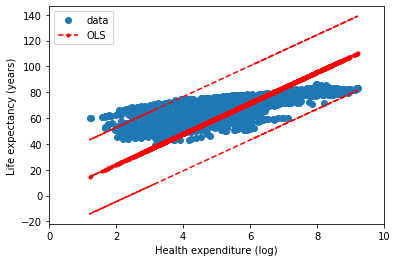

In [9]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def plot_results(results):
    prstd, iv_l, iv_u = wls_prediction_std(results)

    fig, ax = plt.subplots(figsize=(6,4))

    plt.xlabel('Health expenditure (log)')
    plt.ylabel('Life expectancy (years)')
    plt.xlim(0,10)

    ax.plot(x, y, 'o', label="data")
    ax.plot(x, results.fittedvalues, 'r--.', label="OLS")
    ax.plot(x, iv_u, 'r--')
    ax.plot(x, iv_l, 'r--')
    ax.legend(loc='best');
plot_results(results)

It doesn't seem our model is actually fitting the data. Let's try again by adding the intercept component

                               OLS Regression Results                              
Dep. Variable:     Life expectancy (years)   R-squared:                       0.656
Model:                                 OLS   Adj. R-squared:                  0.656
Method:                      Least Squares   F-statistic:                     5807.
Date:                     Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                             22:13:50   Log-Likelihood:                -9442.5
No. Observations:                     3050   AIC:                         1.889e+04
Df Residuals:                         3048   BIC:                         1.890e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

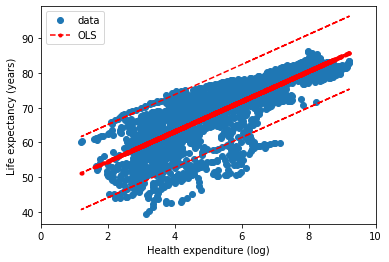

In [10]:
model = sm.OLS(y, sm.add_constant(x))
results = model.fit()
print(results.summary())
plot_results(results)

Now the R-squared has decreased to 0.656. But the line and slope seems to fit much better the data. What could be happening?

Let's compare to linearmodels implementation

#### 3.2.- linearmodels implementation

First model: linearmodels.PooledOLS with default parameters (no intercept)

In [11]:
from linearmodels import PooledOLS

# MultiIndex, entity - time
data = df_xy.set_index(['Entity','Year'])

# Create column life_expectancy without spaces to avoid problems with from_formula()
data['life_expectancy'] =data['Life expectancy (years)']
mod = PooledOLS.from_formula("life_expectancy ~ 0+ health_expenditure_log",data)
res = mod.fit()
res

Dep. Variable:,life_expectancy,R-squared:,0.9567
Estimator:,PooledOLS,R-squared (Between):,0.9600
No. Observations:,3050,R-squared (Within):,-2.7660
Date:,"Mon, Jul 13 2020",R-squared (Overall):,0.9567
Time:,22:13:50,Log-likelihood,-1.251e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.739e+04
Entities:,172,P-value,0.0000
Avg Obs:,17.733,Distribution:,"F(1,3049)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,6.739e+04


We get same suspicious 0.957 coefficient of determination. Though in this case we have additional information: `R-squared (Between)` is 0.96 but `R-squared (Within)` is -2.77. According to the corresponding definitions ([Source](https://www.statalist.org/forums/forum/general-stata-discussion/general/1314121-r-squared-within-between-overall)):
- The `R-squared (Between)` is "How much of the variance between separate panel units does my model account for" Or in other words this computes the fitted values using the
fixed-effects parameter vector and the within-individual means of the
indepdenent variables.  Then calculates the r-squared as the squared
correlation between those predicted values and the within-individual
means of the original y variable. [Source](https://www.stata.com/statalist/archive/2006-08/msg00399.html)
- The `R-squared (Within)` is "How much of the variance within the panel units does my model account for". 
- And the `R-squared (Overall)` is a weighted average of these two. Or the usual 𝑅2 which you would get from regressing your dependent variable 𝑌𝑖,𝑡 on the explanatory variables 𝑋𝑖,𝑡 ([Source](https://stats.stackexchange.com/questions/79723/interpretation-of-r2-in-fixed-effects-panel-regression))



In [12]:
mod = PooledOLS.from_formula("life_expectancy ~ 1+ health_expenditure_log",data)
res = mod.fit()
res

Dep. Variable:,life_expectancy,R-squared:,0.6558
Estimator:,PooledOLS,R-squared (Between):,0.6697
No. Observations:,3050,R-squared (Within):,0.4457
Date:,"Mon, Jul 13 2020",R-squared (Overall):,0.6558
Time:,22:13:50,Log-likelihood,-9442.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5807.3
Entities:,172,P-value,0.0000
Avg Obs:,17.733,Distribution:,"F(1,3048)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,5807.3


As we can see, if we add the intercept of our PooledOLS model we get similar `R-squared (Overall)` as with the last statsmodel OLS execution, 0.656. Moreover, `R-squared (Within)` is still positive, unlike in case of PooledOLS model with no intercept

##### 3.2.1.- Fixed Effects Model vs Random Effects Model
The *Fixed Effects Model* can be considered like a variant of OLS for longitudinal or panel data where one specific intercept is considered for each Entity (Country) (or time unit). This is similar to consider one dummy (binary) variable for each Entity. Or analogous, describe the Entity as a category or factor codified with [one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). The Fixed Effects Model is also known as the Within estimator.

For linearmodels FixedEffects is implemented in PanelOLS methods

In [13]:
from linearmodels import PanelOLS
mod = PanelOLS.from_formula("life_expectancy ~ 1+ health_expenditure_log",data)
res = mod.fit()
res

Dep. Variable:,life_expectancy,R-squared:,0.6558
Estimator:,PanelOLS,R-squared (Between):,0.6697
No. Observations:,3050,R-squared (Within):,0.4457
Date:,"Mon, Jul 13 2020",R-squared (Overall):,0.6558
Time:,22:13:50,Log-likelihood,-9442.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5807.3
Entities:,172,P-value,0.0000
Avg Obs:,17.733,Distribution:,"F(1,3048)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,5807.3


With no extra parameters in the formula, the behavior of PanelOLS is similar to PooledOLS. But we can try with `EntityEffects`. A flag whether to include entity (fixed) effects in the model

In [14]:
from linearmodels import PanelOLS
mod = PanelOLS.from_formula("life_expectancy ~ 1+ health_expenditure_log + EntityEffects",data)
res = mod.fit()
res

Dep. Variable:,life_expectancy,R-squared:,0.4886
Estimator:,PanelOLS,R-squared (Between):,0.6300
No. Observations:,3050,R-squared (Within):,0.4886
Date:,"Mon, Jul 13 2020",R-squared (Overall):,0.6215
Time:,22:13:51,Log-likelihood,-5690.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2749.0
Entities:,172,P-value,0.0000
Avg Obs:,17.733,Distribution:,"F(1,2877)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,2749.0


`R-squared (Within)` has slightly increased from 0.446 to 0.489. At the cost of decrease both `R-squared (Between)` and `R-squared (Overall)`

By default **FixedEffects** uses only means and does note require constructing dummy variables for each effect. We'll try also with `use_lsdv=True` for Least Squares Dummy Variable implementation. And check we got exactly the same results.

In [15]:
from linearmodels import RandomEffects
mod = PanelOLS.from_formula("life_expectancy ~ 1+ health_expenditure_log + EntityEffects",data)
res = mod.fit(use_lsdv=True)
res

Dep. Variable:,life_expectancy,R-squared:,0.4886
Estimator:,PanelOLS,R-squared (Between):,0.6300
No. Observations:,3050,R-squared (Within):,0.4886
Date:,"Mon, Jul 13 2020",R-squared (Overall):,0.6215
Time:,22:13:51,Log-likelihood,-5690.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2749.0
Entities:,172,P-value,0.0000
Avg Obs:,17.733,Distribution:,"F(1,2877)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,2749.0


The **Random Effects** Model can be considered another variant of OLS for panel data. In  the  random  effects  model,  the  individual-specific  effect  is  a  randomvariable that is uncorrelated with the explanatory variables [Source](https://www.schmidheiny.name/teaching/panel2up.pdf)

In [16]:
from linearmodels import RandomEffects
mod = RandomEffects.from_formula("life_expectancy ~ 1+ health_expenditure_log",data)
res = mod.fit()
res

Dep. Variable:,life_expectancy,R-squared:,0.5056
Estimator:,RandomEffects,R-squared (Between):,0.6352
No. Observations:,3050,R-squared (Within):,0.4884
Date:,"Mon, Jul 13 2020",R-squared (Overall):,0.6263
Time:,22:13:51,Log-likelihood,-5787.4
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3117.2
Entities:,172,P-value,0.0000
Avg Obs:,17.733,Distribution:,"F(1,3048)"
Min Obs:,1.0000,,
Max Obs:,18.000,F-statistic (robust):,3056.4


In this case, with RandomEffects we got same `R-squared (Within)` than Fixed Entity Effects, 0.4884, but slightly higher `R-squared (Between)` and consequently `R-squared (Overall)`. Anyway both lower than in case of PooledOLS model

#### 3.3.- Scikit-learn implementation

First model: sklearn.linear_model.LinearRegression (OLS) with default parameters (intercept=True)

In [17]:
from sklearn import datasets
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

x = data.loc[:,'health_expenditure_log'].values.reshape(-1,1)
y = data.loc[:,'life_expectancy']#.values.reshape(-1,1)

# We won't do the typical train_test_split in order to compare exactly with the previous models on the training set
# If we would like our model to generalize, we should preferable do train_test_split, or similar technique
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = x
y_train = y
X_test = x
y_test = y

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.coef_)
# The intercept
print('Intercept: \n', model.intercept_)
# The root mean squared error
print('Root mean squared error: {:.2f} (years)'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
# The mean absolute error
print('Mean absolute error: {:.2f} (years)'.format(mean_absolute_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction

y_pred = model.intercept_+np.sum(x* model.coef_, axis=1)
print('Coefficient of determination (r2_score): {:.3f}'.format(r2_score(y_test, y_pred)))

Coefficients: 
 [4.32561585]
Intercept: 
 45.97283057246861
Root mean squared error: 5.35 (years)
Mean absolute error: 3.93 (years)
Coefficient of determination (r2_score): 0.656


We get same coefficient 4.326 as with `statsmodels` (api.OLS) and `linearmodels` (PooledOLS and PanelOLS without EntityEffects). And same coefficient of determination `r2_score` (`R-squared (Overall)`)

We can study the asymmetry of the coefficient of determination and its relation to Pearson's correlation metric by comparing the results from different R2 implementations:

In [18]:
print('r2_score is not symmetric, and we can compare {:.3f} and {:.3f}'.format(r2_score(y_test, y_pred),r2_score(y_pred, y_test)))

#The coefficient R^2 is defined as (1 - u/v)
def my_r2_score(y,x):
    y_true = y
    y_pred = x
    u=((y_true - y_pred) ** 2).sum()
    v=((y_true - y_true.mean()) ** 2).sum()
    r2 = (1 - u/v)
    return(r2)

print('my_r2_score as (1 - u/v) is not symmetric, and we can compare {:.3f} and {:.3f}'.format(my_r2_score(y_test, y_pred),my_r2_score(y_pred, y_test)))

print("\nOther implementations of R2:")
import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2
print("R2 from scipy.stats.linregress squared: {:.3f}".format(rsquared(X_train.reshape(1,-1),y_train)))

def corrcoef_squared(x,y):
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return(r_squared)
print("R2 from corrcoef squared: {:.3f}".format(corrcoef_squared(X_train.reshape(1,-1),y_train)))

# TODO why model.score get different coefficient of determination estimate? -936.12 vs 0.656
# model.score(y_pred.reshape(-1,1),y_test)
# model.score(y_pred.reshape(-1,1),y_test.values.reshape(-1,1))


r2_score is not symmetric, and we can compare 0.656 and 0.475
my_r2_score as (1 - u/v) is not symmetric, and we can compare 0.656 and 0.475

Other implementations of R2:
R2 from scipy.stats.linregress squared: 0.656
R2 from corrcoef squared: 0.656


/home/milhouse/tools/virtualenvs/worldindata/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/milhouse/tools/virtualenvs/worldindata/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


And finally we plot the data and model (again)

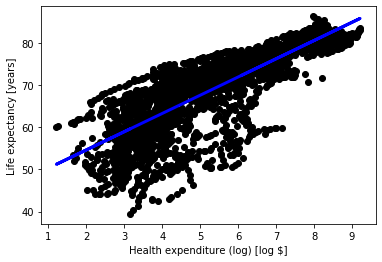

In [19]:
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xlabel('Health expenditure (log) [log $]')
plt.ylabel('Life expectancy [years]')
plt.show()